In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
from itertools import combinations

### Reading IDs of selected magnetic Cataclysmic Variables

In [2]:
objids_list = list(pd.read_csv('../data/magnetic_cvs_objectId.csv').values.flatten())

### Getting data of selected magCVs from Fink's API

Get data from Fink

In [3]:
# retrieve full objects data
r = requests.post(
  "https://api.fink-portal.org/api/v1/objects",
  json={
    "objectId": ",".join(objids_list),
    "columns": "i:objectId,d:anomaly_score,d:lc_features_g,d:lc_features_r",
    "output-format": "json"
  }
)

### Formatting output in a DataFrame

In [4]:
pdf = pd.read_json(io.BytesIO(r.content))
pdf

,i:objectId,d:anomaly_score,d:lc_features_g,d:lc_features_r
0,ZTF17aaarvmd,NaN,[],[]
1,ZTF18aaadlpa,-0.207629,"[18.805038361213605, 18.97971454799683, 1.4069...","[19.072515062537434, 17.565052863600965, 1.035..."
2,ZTF18abnulwr,-0.019535,"[21.797781262525547, 21.443444600246625, 0.618...","[23.285054981784537, 22.903822703409396, 0.652..."
3,ZTF18aaqphee,-0.012197,"[20.001228861637856, 19.99264607715552, 0.1770...","[19.19776281066766, 19.179895917835594, 0.0864..."
4,ZTF18abwiccd,NaN,[],[]
...,...,...,...,...
24615,ZTF18abwiccd,NaN,[],[]
24616,ZTF18aavooiu,NaN,[],[]
24617,ZTF18aabjjas,NaN,[],[]
24618,ZTF18abtcyai,NaN,[],[]


In [5]:
feature_names = ['mean', 'weighted_mean', 'standard_deviation', 'median', 'amplitude', 'beyond_1_std', 'cusum',
                 'inter_percentile_range_10', 'kurtosis', 'linear_trend', 'linear_trend_sigma', 'linear_trend_noise',
                 'linear_fit_slope', 'linear_fit_slope_sigma', 'linear_fit_reduced_chi2', 'magnitude_percentage_ratio_40_5',
                 'magnitude_percentage_ratio_20_10', 'maximum_slope', 'median_absolute_deviation', 'median_buffer_range_percentage_10',
                 'percent_amplitude', 'mean_variance', 'anderson_darling_normal', 'chi2', 'skew', 'stetson_K']

### Cleaning data

In [6]:
features_g, features_r = [], []
for i in range(len(pdf)): # Converting values from str to float
    features_g.append(np.array(eval(pdf['d:lc_features_g'][i].replace("NaN", "np.nan").replace("null", "np.nan"))))
    features_r.append(np.array(eval(pdf['d:lc_features_r'][i].replace("NaN", "np.nan").replace("null", "np.nan"))))

pdf['d:lc_features_g'] = features_g
pdf['d:lc_features_r'] = features_r

In [7]:
clean_pdf = pdf[~np.isnan(pdf["d:anomaly_score"])] # Getting rid of lines with NaN in the anomaly_score column

clean_pdf_g = clean_pdf.drop(columns=["d:lc_features_r"])
clean_pdf_r = clean_pdf.drop(columns=["d:lc_features_g"])

for index, lc_features_g, lc_features_r in zip(clean_pdf.index, clean_pdf_g["d:lc_features_g"], clean_pdf_r["d:lc_features_r"]):
    if len(lc_features_g) == 0 or True in np.isnan(lc_features_g):
        clean_pdf_g = clean_pdf_g.drop([index]) # Getting rid of lines with NaN or empty lc_features
    if len(lc_features_r) == 0 or True in np.isnan(lc_features_r):
        clean_pdf_r = clean_pdf_r.drop([index])

In [8]:
print(f'{len(clean_pdf_g)} and {len(clean_pdf_r)} lines remaining in g and r filters respectively after cleaning out of {len(pdf)}')

4324 and 4268 lines remaining in g and r filters respectively after cleaning out of 24620


### Removing duplicates

In [9]:
features_g, features_r = np.vstack(clean_pdf_g["d:lc_features_g"].to_numpy()), np.vstack(clean_pdf_r["d:lc_features_r"].to_numpy())
# Used vstack here to have 2D arrays instead of array of arrays
features_g_reduced = np.unique(features_g, axis=0)
features_r_reduced = np.unique(features_r, axis=0)
print(f'{len(features_g_reduced)} out of {len(features_g)} and {len(features_r_reduced)} out of {len(features_r)} lines remaining in g and r filters respectively after removing duplicates')

3762 out of 4324 and 3920 out of 4268 lines remaining in g and r filters respectively after removing duplicates


### Corner plots of some features

In [10]:
def corner_plot(df: pd.DataFrame) -> None:
    """Make a corner plot which dimension is the number of columns of the DataFrame

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
    """
    n = len(df.columns) # Dimension of the corner plot
    # Plotting histograms:
    index = 1
    for feature in df.columns:
        plt.subplot(n, n, index)
        index += n + 1
        plt.hist(df[feature], bins=np.linspace(min(df[feature]), max(df[feature]), 30))
    # Positions for scatter plots:
    positions = []
    for i in range(1, n):
        for j in range(i, n):
            positions.append(j*n + i)
    positions
    # Plotting scatter plots:
    for position, feature_pair in zip(positions, tuple(combinations(df.columns, 2))):
        plt.subplot(n, n, position)
        plt.scatter(df[feature_pair[0]], df[feature_pair[1]], s=1, alpha=0.1)
    return


In [11]:
dfg = pd.DataFrame(features_g_reduced, columns=feature_names)
dfr = pd.DataFrame(features_r_reduced, columns=feature_names)

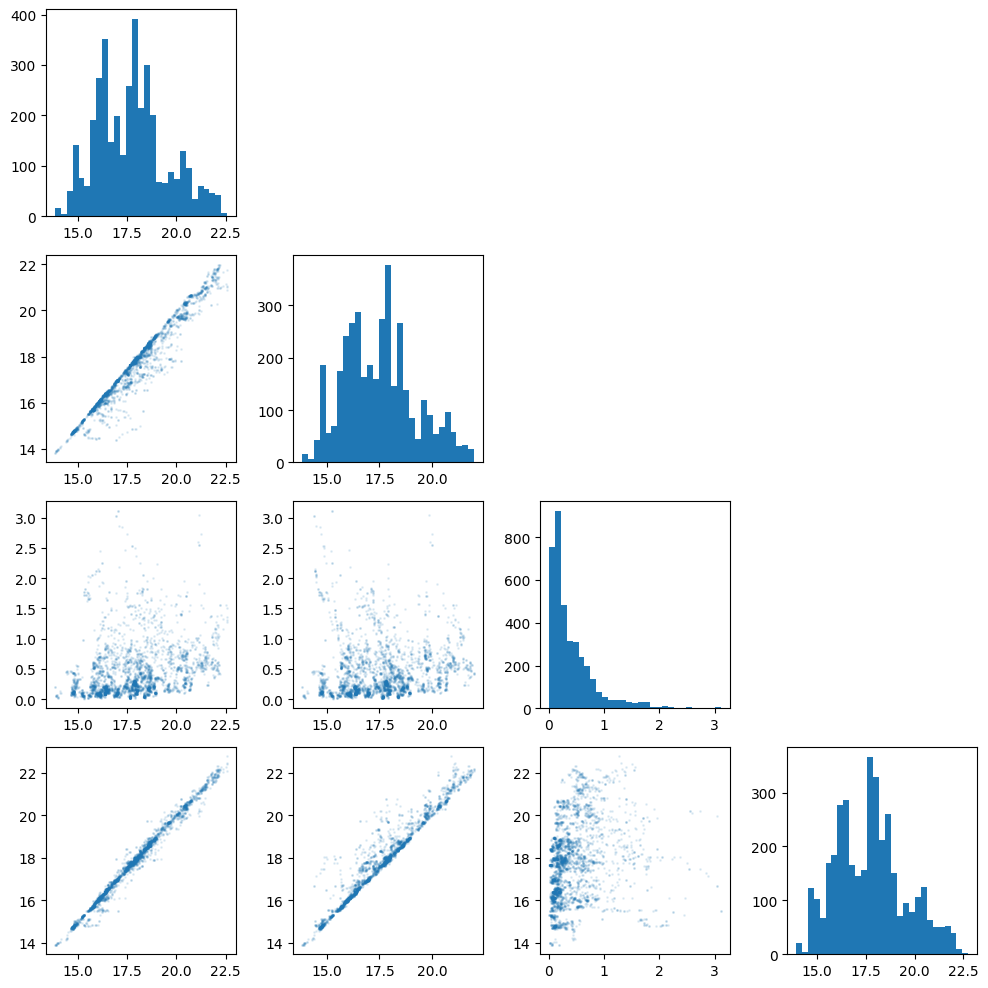

In [12]:
plt.figure(figsize=(10, 10))
corner_plot(dfg[feature_names[:4]])
plt.tight_layout()